# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.
9. SGD performed much faster, but not very accurate
9. Interpreted Logistic Model - only 4 variables worth keeping
10. Reduced logistic model performs about the same, but much simpler
11. SGD classifier is faster than logistic.
12. SVM on reduced model takes a long time and is less accurate on this data set and features.

## SVM and Logistic Regression Modeling  
* <font color = "green">[50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. </font>
* <font color = "red">[10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* <font color = "green">[30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? </font>
* <font color = "red">[10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [13]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings

# Read in preprocessed data from previous assignment

In [2]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [3]:
print(cc_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [4]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

#### Convert data to numpy arrays for training

In [5]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [6]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [7]:
# Create Cross Validation object with an 80/20 split
num_cv_iterations = 10
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [8]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

### Review of different parameters

In [9]:
def grid_searcher(X, y, model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(X, y)
    return clf

In [10]:
# set parameters for grid search to test all the different combinations
c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

#run search and return results
logit_clf = grid_searcher(cc_data_Xs, cc_data_target, model, params, cv_object)

#print(clf.grid_scores_ )
print("The best estimator: ",logit_clf.best_estimator_)
print("The best accuracy score is: ", logit_clf.best_score_)
print("The best parameters of model is: ",logit_clf.best_params_)

The best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best accuracy score is:  0.810383333333
The best parameters of model is:  {'penalty': 'l1', 'class_weight': None, 'C': 1}


### The grid search reveals 
Grid search reveals: Penalty - l1 was selected over l2, which means that the objective function that is minimized is better for L1, which is the sum of errors, rather than L2, which is the sum of squared errors. L1 is less sensitive to outliers. The C=10 value indicates a larger value is needed for regularization which improves the models ability to not fit to noise. Class_weight selection of None over balanced means balanced did not add accuracy to the fit, likely because 'balanced' mode "uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data" The best accuracy score is 0.812 is just slightly better accuracy than predicting all non-defaults of 77.9%.

### Find coefficients 

In [14]:
def full_classify(X, y, cv_object, model, scale=False):
    start = time.time()
    # Create empty list to append coefficient results
    coef_list = []
    acc_list = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        print("====Iteration",iter_num," ====")
        if scale == True:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scl_obj = StandardScaler()
                scl_obj.fit(X[train_indices])
                X_train_scaled = scl_obj.transform(X[train_indices])
                X_test_scaled = scl_obj.transform(X[test_indices])
                model.fit(X_train_scaled,y[train_indices])
                y_hat = model.predict(X_test_scaled)
                print("\n*SCALED DATA*")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions
        
        # append coefficients from model to list
        coef_list.append(model.coef_)
        acc_list.append(mt.accuracy_score(y[test_indices],y_hat))

        # print the accuracy and confusion matrix 
        #print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat))
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        print()
        
    print('done. It took', time.time()-start, 'seconds.')    
    return coef_list, acc_list

In [15]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
logit_coef_scaled, logit_acc_scaled = full_classify(cc_data_Xs, cc_data_target, cv_object, logit_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.8175
confusion matrix
 [[4596  123]
 [ 972  309]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4719
          1       0.72      0.24      0.36      1281

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.607576477174

====Iteration 1  ====

*SCALED DATA*
accuracy 0.810333333333
confusion matrix
 [[4570  137]
 [1001  292]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4707
          1       0.68      0.23      0.34      1293

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.598362906211

====Iteration 2  ====

*SCALED DATA*
accuracy 0.814833333333
confusion matrix
 [[4579  136]
 [ 975  310]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4715
          1       0.70   

### Intrepretting weights of Logistic Model using Scaled Data

In [16]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def analysis(coef_list, acc_list, labels):
    # Below averages the output of the cross validations
    coef_list_avg = np.array(np.mean(coef_list, axis=0 ))
    acc_list_avg = np.mean(acc_list)

    print("The average accuracy score is: ", acc_list_avg)

    # Sanity check to make sure the column name list is the same length as the coefficients
    print("Coefficients and column names same length: " + str(len(coef_list_avg.T)==len(labels)))
    print()

    # print coefficients with label
    zip_vars = zip(coef_list_avg.T,labels) # combine attributes
    for coef, name in zip_vars:
        print(name, 'has weight of', coef[0]) # now print them out

    weights = pd.Series(coef_list_avg[0],index=labels)
    weights.plot(kind='bar')
    plt.show()

The average accuracy score is:  0.811033333333
Coefficients and column names same length: True

EDUCATION has weight of -0.00168951910529
PAY_0_Sept has weight of 0.653232573843
PAY_2_Aug has weight of 0.104509355805
PAY_3_July has weight of 0.0923841175753
PAY_4_June has weight of 0.0187585931221
PAY_5_May has weight of 0.0423202854077
PAY_6_April has weight of 0.0205396029722
BILL_AMT1_Sept has weight of -0.430838041295
BILL_AMT2_Aug has weight of 0.160948912743
BILL_AMT3_July has weight of 0.116022877806
BILL_AMT4_June has weight of -0.0307112747318
BILL_AMT5_May has weight of 0.0574870729715
BILL_AMT6_April has weight of 0.01140755171
PAY_AMT1_Sept has weight of -0.222112219852
PAY_AMT2_Aug has weight of -0.213265657919
PAY_AMT3_July has weight of -0.0612274026497
PAY_AMT4_June has weight of -0.0709142431099
PAY_AMT5_May has weight of -0.0509467978216
PAY_AMT6_April has weight of -0.047109402994
AGE_range has weight of 0.0374682730299
LIMIT_BAL_range has weight of -0.0280099692303


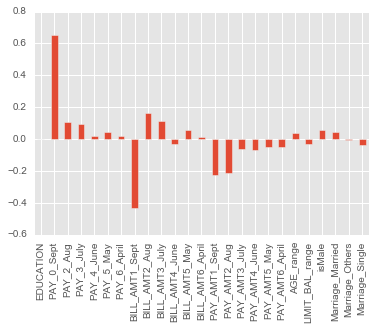

In [17]:
analysis(logit_coef_scaled, logit_acc_scaled, cc_data_Xs_names)

### Logitic Interpretation of Full Model

PAY_0_Sept and BILL_AMT1_Sept are the two strongest indicators of default. Pay_0_Sept and Bill_AMT1_Sept have high weights, >0.4 and <-0.4 respectively, compared to the other coefficients and are significant to the model. Secondarily, PAY_AMT1_Sept and PAY_AMT2_Aug have a similar strength of indicators. PAY_0_Sept indicates how many months late is the payment, so it is logical that as this increases the log odd of default would increase as well. BILL_AMT1 indicates the amount billed, and the weighting suggest counter to logic that bigger bills tended to default less frequently. Due to the high multicollinearity of the BILL_AMT variables, as discovered previously in project 1, this weighting might not be trustable. PAY_AMT1_Sept and PAY_AMT2_Aug have a negative weighting, suggesting as pay amounts decrease during these months, default goes higher.

### Reduced Logistic Model

In [18]:
logit_reduced_model = ['PAY_0_Sept',
                       'BILL_AMT1_Sept',
                       'PAY_AMT1_Sept',
                       'PAY_AMT2_Aug']

cc_data_Xs_logit_reduced = cc_data_processed[logit_reduced_model].values

# Column names for labeling
cc_data_Xs_names_lr = cc_data_processed[logit_reduced_model].columns

In [19]:
logit_coef_scaled_lr, logit_acc_scaled_lr = full_classify(cc_data_Xs_logit_reduced, cc_data_target,  cv_object, 
                                                          logit_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.810333333333
confusion matrix
 [[4528  162]
 [ 976  334]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4690
          1       0.67      0.25      0.37      1310

avg / total       0.79      0.81      0.78      6000

ROC Score 
 0.610210127118

====Iteration 1  ====

*SCALED DATA*
accuracy 0.808333333333
confusion matrix
 [[4490  149]
 [1001  360]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4639
          1       0.71      0.26      0.39      1361

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.616196198761

====Iteration 2  ====

*SCALED DATA*
accuracy 0.8205
confusion matrix
 [[4553  149]
 [ 928  370]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4702
          1       0.71   

The average accuracy score is:  0.814033333333
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.814868375171
BILL_AMT1_Sept has weight of -0.128287509554
PAY_AMT1_Sept has weight of -0.206584021648
PAY_AMT2_Aug has weight of -0.262202777898


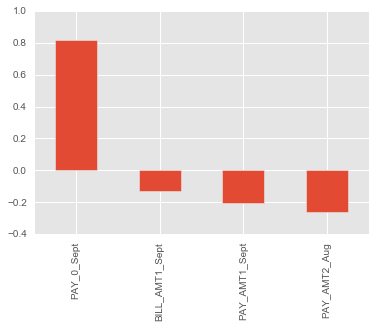

In [20]:
analysis(logit_coef_scaled_lr, logit_acc_scaled_lr, cc_data_Xs_names_lr)

### Comparison of Full Model to Reduced Model

The reduced model supports the analysis of the full model variable determined to be unecessary. The full model accuracy was 81.3% compared to the reduced model of 81.2%. Both the full and reduced model perform slightly better the an all no-default prediction of 77.9%. PAY_0_Sept increased from .65 to .81 and strengthened in the reduced model. BILL_AMT1_Sept reduced to -.13 making it less strong of a predictor. PAY_AMT1_Sept and PAY_AMT2_Aug stayed about the same.

    Full:
    PAY_0_Sept has weight of 0.653232573843
    BILL_AMT1_Sept has weight of -0.430838041295
    PAY_AMT1_Sept has weight of -0.222112219852
    PAY_AMT2_Aug has weight of -0.213265657919

    Reduced:
    PAY_0_Sept has weight of 0.814868375171
    BILL_AMT1_Sept has weight of -0.128287509554
    PAY_AMT1_Sept has weight of -0.206584021648
    PAY_AMT2_Aug has weight of -0.262202777898

## Support Vector Machine - Using SGDClassifier

In [21]:
# Create New Cross Validation object
svg_cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=10, test_size  = 0.2)

# Initial fixed parmeters
model = SGDClassifier(loss='hinge', n_iter=3, learning_rate='optimal')

# Parameteres to search on:
params = {'penalty':('l1','l2'),
          'fit_intercept':(True, False),
          'average':(True,False),
          'alpha':[.000001, .00001, .0001]} 
          #'alpha':np.arange(.00001, .001, 0.00005)}

# Run grid search with cv_object
sgd_clf = grid_searcher(cc_data_Xs, cc_data_target, model, params, svg_cv_object)

# Print grid serach results
print("The best estimator: ",sgd_clf.best_estimator_)
print("The best accuracy score is: ", sgd_clf.best_score_)
print("The best parameters of model is: ",sgd_clf.best_params_)

The best estimator:  SGDClassifier(alpha=1e-05, average=True, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=3, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
The best accuracy score is:  0.78
The best parameters of model is:  {'penalty': 'l1', 'average': True, 'alpha': 1e-05, 'fit_intercept': False}


In [22]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
sgd_coef_scaled, sgd_acc_scaled = full_classify(cc_data_Xs, cc_data_target, cv_object, sgd_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.550833333333
confusion matrix
 [[2417 2272]
 [ 423  888]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.52      0.64      4689
          1       0.28      0.68      0.40      1311

avg / total       0.73      0.55      0.59      6000

ROC Score 
 0.596403628337

====Iteration 1  ====

*SCALED DATA*
accuracy 0.5785
confusion matrix
 [[2560 2130]
 [ 399  911]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.55      0.67      4690
          1       0.30      0.70      0.42      1310

avg / total       0.74      0.58      0.61      6000

ROC Score 
 0.620631032406

====Iteration 2  ====

*SCALED DATA*
accuracy 0.56
confusion matrix
 [[2350 2334]
 [ 306 1010]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.50      0.64      4684
          1       0.30      0.77   

The average accuracy score is:  0.564233333333
Coefficients and column names same length: True

EDUCATION has weight of 0.148607387008
PAY_0_Sept has weight of 13.053482645
PAY_2_Aug has weight of 3.58688416982
PAY_3_July has weight of 1.76654151484
PAY_4_June has weight of 2.53507373026
PAY_5_May has weight of 1.58251724955
PAY_6_April has weight of 0.270904226348
BILL_AMT1_Sept has weight of -5.94482030176
BILL_AMT2_Aug has weight of 0.545065801433
BILL_AMT3_July has weight of 0.000571966026425
BILL_AMT4_June has weight of -1.85810344136
BILL_AMT5_May has weight of 1.96153885103
BILL_AMT6_April has weight of -2.3794252247
PAY_AMT1_Sept has weight of -7.07208706179
PAY_AMT2_Aug has weight of -10.1701097083
PAY_AMT3_July has weight of -3.98998300133
PAY_AMT4_June has weight of -4.1063813293
PAY_AMT5_May has weight of -1.07742468924
PAY_AMT6_April has weight of -2.10003212543
AGE_range has weight of 2.00540573592
LIMIT_BAL_range has weight of 0.110345155171
isMale has weight of -0.50589

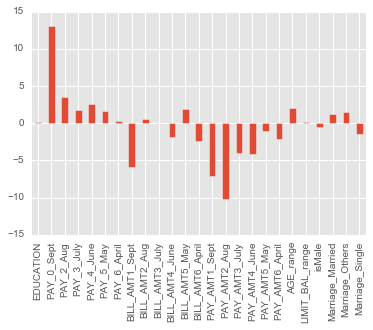

In [23]:
analysis(sgd_coef_scaled, sgd_acc_scaled, cc_data_Xs_names)

## SGD Full Model Interpretation

Like the previous logistic model, 'PAY_0_Sept', 'BILL_AMT1_Sept', 'PAY_AMT1_Sept', and 'PAY_AMT2_Aug' are important predictors to default. Also evident is the multicollinearity BILL_AMT features, with BILL_AMT1 showing the strongest predictor and BILL_AMT2 - BILL_AMT6 not at all. 'PAY_AMT1_Sept' and 'PAY_AMT2_Aug' also standout.

## SGD Reduced Model

In [24]:
svg_reduced_model = ['PAY_0_Sept',
                     'BILL_AMT1_Sept',
                     'PAY_AMT1_Sept',
                     'PAY_AMT2_Aug']

cc_data_Xs_svg_reduced = cc_data_processed[svg_reduced_model].values

# Column names for labeling
cc_data_Xs_names_sr = cc_data_processed[svg_reduced_model].columns

In [25]:
sgd_coef_scaled_sr, sgd_acc_scaled_sr = full_classify(cc_data_Xs_svg_reduced, cc_data_target, cv_object, 
                                                sgd_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.520666666667
confusion matrix
 [[2153 2579]
 [ 297  971]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.45      0.60      4732
          1       0.27      0.77      0.40      1268

avg / total       0.75      0.52      0.56      6000

ROC Score 
 0.610380095517

====Iteration 1  ====

*SCALED DATA*
accuracy 0.53
confusion matrix
 [[2154 2500]
 [ 320 1026]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.46      0.60      4654
          1       0.29      0.76      0.42      1346

avg / total       0.74      0.53      0.56      6000

ROC Score 
 0.612543109476

====Iteration 2  ====

*SCALED DATA*
accuracy 0.521666666667
confusion matrix
 [[2169 2494]
 [ 376  961]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.47      0.60      4663
          1       0.28     

The average accuracy score is:  0.510416666667
Coefficients and column names same length: True

PAY_0_Sept has weight of 3.10510753163
BILL_AMT1_Sept has weight of 0.106141889915
PAY_AMT1_Sept has weight of -2.1774811581
PAY_AMT2_Aug has weight of -3.33324709372


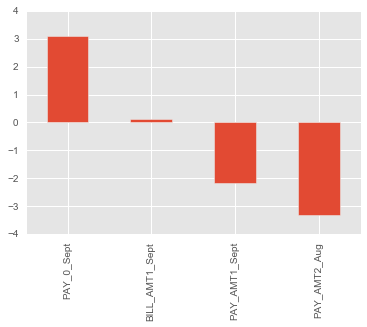

In [26]:
analysis(sgd_coef_scaled_sr, sgd_acc_scaled_sr, cc_data_Xs_names_sr)

#### Reduced Model Analysis
Compared to the full SGD model the reduced model has an average accuracy of 79.5% compared to 81.2%, which is not much more than an all no-default prediction of 77.9%. On this given data set and features the SGD performs slightly worse compared to the logistic regression model.

### Reduced Model us SVC

In [27]:
model = SVC(kernel='linear', C=1)
svc_coef_scaled_r, svc_acc_scaled_r = full_classify(cc_data_Xs_svg_reduced, cc_data_target, cv_object, 
                                                         model, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.790833333333
confusion matrix
 [[4745    0]
 [1255    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.79      1.00      0.88      4745
          1       0.00      0.00      0.00      1255

avg / total       0.63      0.79      0.70      6000

ROC Score 
 0.5

====Iteration 1  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.7785
confusion matrix
 [[4671    0]
 [1329    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.78      1.00      0.88      4671
          1       0.00      0.00      0.00      1329

avg / total       0.61      0.78      0.68      6000

ROC Score 
 0.5

====Iteration 2  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.7755
confusion matrix
 [[4653    0]
 [1347    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.78      1.00      0.87      4653
          1       0.00      0.00      0.00      1347

avg / total       0.60      0.78      0.68      6000

ROC Score 
 0.5

====Iteration 3  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.777333333333
confusion matrix
 [[4664    0]
 [1336    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.78      1.00      0.87      4664
          1       0.00      0.00      0.00      1336

avg / total       0.60      0.78      0.68      6000

ROC Score 
 0.5

====Iteration 4  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.7795
confusion matrix
 [[4677    0]
 [1323    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.78      1.00      0.88      4677
          1       0.00      0.00      0.00      1323

avg / total       0.61      0.78      0.68      6000

ROC Score 
 0.5

====Iteration 5  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.786166666667
confusion matrix
 [[4717    0]
 [1283    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.79      1.00      0.88      4717
          1       0.00      0.00      0.00      1283

avg / total       0.62      0.79      0.69      6000

ROC Score 
 0.5

====Iteration 6  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.772666666667
confusion matrix
 [[4636    0]
 [1364    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.77      1.00      0.87      4636
          1       0.00      0.00      0.00      1364

avg / total       0.60      0.77      0.67      6000

ROC Score 
 0.5

====Iteration 7  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.785833333333
confusion matrix
 [[4715    0]
 [1285    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.79      1.00      0.88      4715
          1       0.00      0.00      0.00      1285

avg / total       0.62      0.79      0.69      6000

ROC Score 
 0.5

====Iteration 8  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.772333333333
confusion matrix
 [[4634    0]
 [1366    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.77      1.00      0.87      4634
          1       0.00      0.00      0.00      1366

avg / total       0.60      0.77      0.67      6000

ROC Score 
 0.5

====Iteration 9  ====


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*SCALED DATA*
accuracy 0.776
confusion matrix
 [[4656    0]
 [1344    0]]
Classification Report:
              precision    recall  f1-score   support

          0       0.78      1.00      0.87      4656
          1       0.00      0.00      0.00      1344

avg / total       0.60      0.78      0.68      6000

ROC Score 
 0.5

done. It took 99.97271800041199 seconds.


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The average accuracy score is:  0.779466666667
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.0003086936738
BILL_AMT1_Sept has weight of -2.51821550781e-05
PAY_AMT1_Sept has weight of -1.40552211838e-05
PAY_AMT2_Aug has weight of -1.4120172758e-05


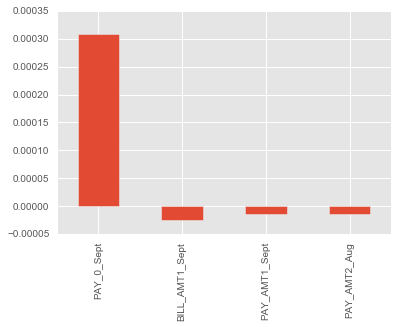

In [28]:
analysis(svc_coef_scaled_r, svc_acc_scaled_r, cc_data_Xs_names_sr)

# Comparison of Logistic Regression and SGD/SVC

Logistic regression has an advantage of accuracy, but the performance is slower than SGD. Logistict regression took about 18 seconds, whereas, SGD took less than 4 seconds. The SGD classifier performance was about the same in terms of the average accuracy. On the other hand, the SVC classifier took so long, it was never completed and stopped after 2 hours. The SVC model on the reduce feature set as determined by the SGD classifier, took 60 seconds and showed it predicted only the 'no default' class. Perhaps further feature engineering could give SVC better performance.